In [ ]:
# Instalação e importação de bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report


import shap
from imblearn.over_sampling import SMOTE
from pycaret.datasets import get_data

In [2]:
# Carregar dados
df_raw = pd.read_csv('/Users/henriquekubo/Documents/repos/health/health_insurance/data/train.csv')
df1 = df_raw.copy()
df1.columns = df1.columns.str.lower()

In [3]:
# Exibir resumo dos dados
print(df1.info())
print(df1.describe().to_markdown(index=True, floatfmt=".2f"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB
None
|       |        id |       age |   driving_license |   region_code |   previously_insured | 

In [4]:
# Engenharia de Recursos
df2 = df1.copy()

In [5]:
# Transformação de vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

# Transformação de vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [6]:
# Criar nova feature: interação entre idade do veículo e dano
df2['vehicle_age_damage'] = df2['vehicle_damage'] * df2['vehicle_age'].map({'below_1_year': 1, 'between_1_2_year': 2, 'over_2_years': 3})

In [7]:
# One-hot encoding para variáveis categóricas
df2 = pd.get_dummies(df2, drop_first=True)

In [8]:
# Análise de desbalanceamento
print("Distribuição da variável resposta:")
print(df2['response'].value_counts(normalize=True) * 100)

Distribuição da variável resposta:
response
0    87.743664
1    12.256336
Name: proportion, dtype: float64


In [9]:
# Verificar classes desbalanceadas
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df2['response']), y=df2['response'])
print(f"Pesos das classes: {class_weights}")


Pesos das classes: [0.56984172 4.07952259]


In [10]:
# Separar variáveis independentes (X) e dependentes (y)
X = df2.drop(columns=['response'])
y = df2['response']

In [11]:
# Dividir em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [12]:
# Aplicar SMOTE apenas no conjunto de treino

smote = SMOTE(random_state=123)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


In [13]:
# Reunir o DataFrame balanceado de treino
train_data = pd.concat([pd.DataFrame(X_train_sm, columns=X.columns), pd.DataFrame(y_train_sm, columns=['response'])], axis=1)

In [14]:
# Configuração do PyCaret
s = setup(
    data=train_data,
    target='response',
    normalize=True,
    session_id=123,
    train_size=0.8,
    fold_strategy='stratifiedkfold',  # Validação estratificada
    fold=10,  # 10 folds para validação cruzada
    )

,Description,Value
0,Session id,123
1,Target,response
2,Target type,Binary
3,Original data shape,"(535038, 14)"
4,Transformed data shape,"(535038, 14)"
5,Transformed train set shape,"(428030, 14)"
6,Transformed test set shape,"(107008, 14)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


In [15]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9132,0.9767,0.8693,0.9529,0.9092,0.8263,0.8295,8.8650
lightgbm,Light Gradient Boosting Machine,0.9022,0.9729,0.8664,0.9333,0.8986,0.8045,0.8066,0.8910
rf,Random Forest Classifier,0.9012,0.9725,0.8926,0.9082,0.9003,0.8024,0.8025,6.8700
et,Extra Trees Classifier,0.8950,0.9701,0.9054,0.8870,0.8961,0.7901,0.7902,3.7980
dt,Decision Tree Classifier,0.8817,0.8817,0.8875,0.8774,0.8824,0.7635,0.7635,0.4210
gbc,Gradient Boosting Classifier,0.8760,0.9605,0.8990,0.8594,0.8788,0.7519,0.7527,7.0540
ada,Ada Boost Classifier,0.8626,0.9530,0.8972,0.8391,0.8672,0.7251,0.7269,1.6710
knn,K Neighbors Classifier,0.8580,0.9322,0.8807,0.8424,0.8611,0.7159,0.7167,8.1720
lr,Logistic Regression,0.8272,0.9142,0.9013,0.7850,0.8391,0.6544,0.6617,0.4400
ridge,Ridge Classifier,0.8182,0.9084,0.9353,0.7579,0.8373,0.6365,0.6547,0.1080


In [19]:
catboost = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9129,0.9763,0.8674,0.9541,0.9087,0.8257,0.8291
1,0.9117,0.9767,0.8694,0.9498,0.9078,0.8234,0.8263
2,0.9137,0.9761,0.8695,0.9539,0.9098,0.8275,0.8307
3,0.9130,0.9767,0.8695,0.9524,0.9091,0.8261,0.8292
4,0.9142,0.9771,0.8722,0.9522,0.9104,0.8284,0.8313
5,0.9121,0.9758,0.8662,0.9538,0.9079,0.8243,0.8278
6,0.9122,0.9766,0.8662,0.9540,0.9080,0.8245,0.8280
7,0.9131,0.9770,0.8700,0.9521,0.9092,0.8263,0.8294
8,0.9137,0.9770,0.8702,0.9531,0.9098,0.8274,0.8306


In [21]:
# Ajustar hiperparâmetros
tuned_cat = tune_model(catboost, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9087,0.9743,0.8692,0.9436,0.9049,0.8173,0.8199
1,0.9070,0.9749,0.8722,0.9373,0.9036,0.8139,0.8159
2,0.9076,0.9743,0.8709,0.9398,0.9041,0.8152,0.8173
3,0.9070,0.9750,0.8711,0.9384,0.9035,0.8140,0.8161
4,0.9086,0.9751,0.8736,0.9394,0.9053,0.8172,0.8192
5,0.9071,0.9740,0.8686,0.9410,0.9033,0.8141,0.8166
6,0.9072,0.9747,0.8688,0.9412,0.9035,0.8145,0.8169
7,0.9080,0.9753,0.8748,0.9371,0.9049,0.8161,0.8179
8,0.9081,0.9748,0.8751,0.9369,0.9050,0.8162,0.8180


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


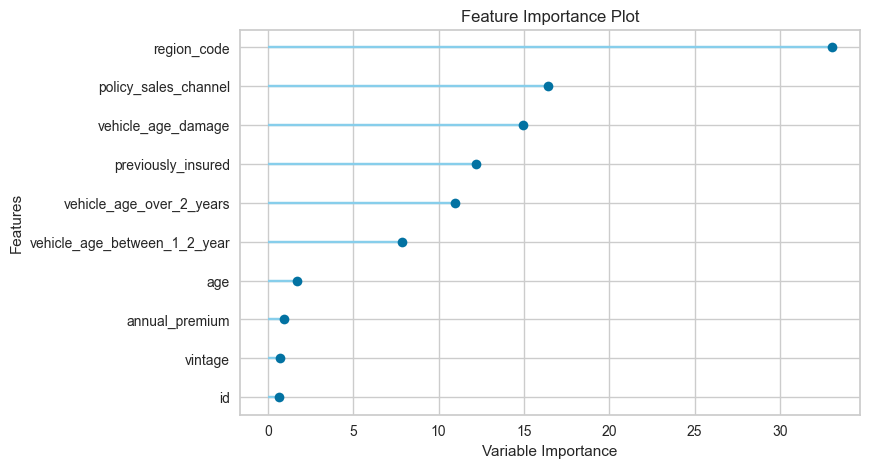

In [22]:
plot_model(tuned_cat, plot='feature')

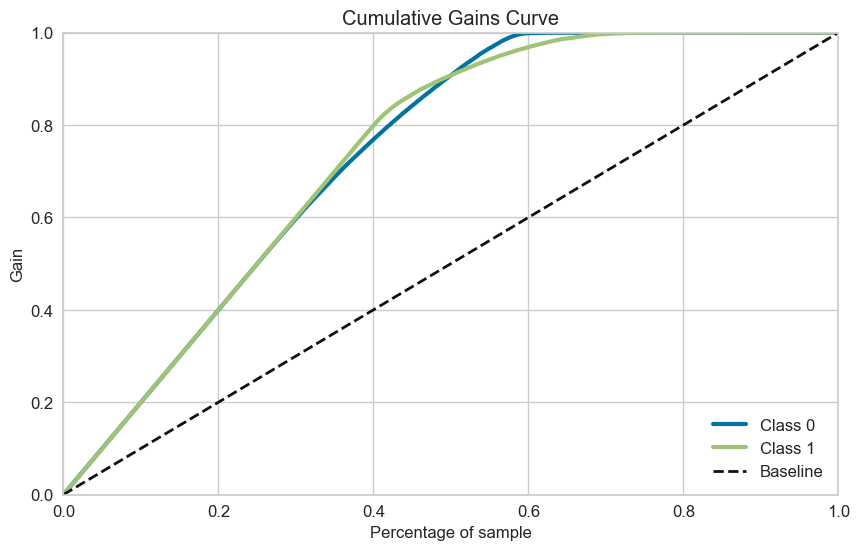

In [23]:
plot_model(tuned_cat, plot = 'gain')

In [24]:
predict_model(tuned_cat)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9160,0.9776,0.8732,0.9550,0.9123,0.8321,0.8352


,id,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_damage,gender_Male,vehicle_age_between_1_2_year,vehicle_age_over_2_years,response,prediction_label,prediction_score
59296,162166,48,1,28.000000,1,0,40447.000000,26.000000,178,0,True,True,False,0,0,0.9996
384304,109440,45,1,39.802120,0,1,33151.992188,69.662186,39,2,True,True,True,1,1,1.0000
263636,348427,23,1,28.000000,0,1,35903.000000,26.000000,47,1,True,False,False,0,0,0.7707
459682,275720,41,1,29.639931,0,1,34107.824219,124.000000,156,2,True,True,True,1,1,1.0000
288130,267345,54,1,8.000000,0,1,34198.000000,124.000000,10,2,True,True,False,0,0,0.8520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502046,317654,55,1,36.004269,0,1,2630.000000,26.000000,51,1,True,True,False,1,1,0.9986
162946,197744,38,1,3.000000,1,0,2630.000000,160.000000,104,0,True,True,False,0,0,0.9988
65027,87617,25,1,33.000000,0,1,28516.000000,152.000000,151,1,False,False,False,0,0,0.8808
301123,13506,68,1,28.000000,0,1,2630.000000,157.000000,268,3,True,False,True,0,0,0.9218


In [25]:
final_cat = finalize_model(tuned_cat)

In [26]:
print(final_cat)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['id', 'age', 'driving_license',
                                             'region_code',
                                             'previously_insured',
                                             'vehicle_damage', 'annual_premium',
                                             'policy_sales_channel', 'vintage',
                                             'vehicle_age_damage'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_feature...
                                    transformer=SimpleImputer(add_indicator=False,
                                      

In [28]:
# Fazer previsões no conjunto de teste
test_predictions = predict_model(final_cat, data=pd.concat([X_test, y_test], axis=1))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8620,0.8484,0.1680,0.3638,0.2298,0.1652,0.1801


In [32]:
# Avaliar o modelo no conjunto de teste
y_test_pred = test_predictions['prediction_label']
print("AUC no conjunto de teste:", roc_auc_score(y_test, y_test_pred))
print("\nRelatório de Classificação no conjunto de teste:")
print(classification_report(y_test, y_test_pred))

AUC no conjunto de teste: 0.5634612400242154

Relatório de Classificação no conjunto de teste:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     66880
           1       0.36      0.17      0.23      9342

    accuracy                           0.86     76222
   macro avg       0.63      0.56      0.58     76222
weighted avg       0.83      0.86      0.84     76222



In [34]:
# Fazer previsões no conjunto de teste
# Aqui estamos passando o conjunto de teste original (X_test + y_test)
test_data = pd.concat([X_test, y_test], axis=1)
test_predictions = predict_model(final_cat, data=test_data)

# Avaliar o desempenho no conjunto de teste
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Extrair os rótulos reais e previstos
y_test_true = test_predictions['response']  # Rótulos reais
y_test_pred = test_predictions['prediction_label']     # Rótulos previstos pelo modelo

# Calcular a AUC no conjunto de teste
auc_test = roc_auc_score(y_test_true, test_predictions['prediction_score'])

# Relatório de classificação
print("Relatório de Classificação no Conjunto de Teste:")
print(classification_report(y_test_true, y_test_pred))

# Matriz de confusão
print("\nMatriz de Confusão no Conjunto de Teste:")
print(confusion_matrix(y_test_true, y_test_pred))

# Imprimir a AUC
print(f"\nAUC no Conjunto de Teste: {auc_test:.4f}")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8620,0.8484,0.1680,0.3638,0.2298,0.1652,0.1801


Relatório de Classificação no Conjunto de Teste:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     66880
           1       0.36      0.17      0.23      9342

    accuracy                           0.86     76222
   macro avg       0.63      0.56      0.58     76222
weighted avg       0.83      0.86      0.84     76222


Matriz de Confusão no Conjunto de Teste:
[[64136  2744]
 [ 7773  1569]]

AUC no Conjunto de Teste: 0.1527


In [36]:
test_predictions = predict_model(final_cat, data=test_data)
# Probabilidade da classe positiva
test_predictions['Probability'] = test_predictions['prediction_score']  # 'Score' é a probabilidade do PyCaret

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8620,0.8484,0.1680,0.3638,0.2298,0.1652,0.1801


In [37]:
ranked_data = test_predictions.sort_values(by='Probability', ascending=False)

In [38]:
ranked_data['Rank'] = pd.qcut(ranked_data['Probability'], q=10, labels=range(10, 0, -1))

In [39]:
# Calcular métricas por faixa de ranqueamento
rank_metrics = ranked_data.groupby('Rank').apply(
    lambda x: pd.Series({
        'Total': len(x),
        'Response_SIM': x['response'].sum(),
        'Response_NAO': len(x) - x['response'].sum(),
        'Percent_SIM': 100 * x['response'].mean()
    })
).reset_index()

# Adicionar cálculo acumulado
rank_metrics['Cumulative_SIM'] = rank_metrics['Response_SIM'].cumsum()
rank_metrics['Cumulative_Percent_SIM'] = 100 * rank_metrics['Cumulative_SIM'] / rank_metrics['Response_SIM'].sum()

print(rank_metrics)

  Rank    Total  Response_SIM  Response_NAO  Percent_SIM  Cumulative_SIM  \
0   10   7624.0        2757.0        4867.0    36.162120          2757.0   
1    9   7628.0        2450.0        5178.0    32.118511          5207.0   
2    8   7617.0        1981.0        5636.0    26.007615          7188.0   
3    7   7626.0        1374.0        6252.0    18.017309          8562.0   
4    6   7624.0         673.0        6951.0     8.827387          9235.0   
5    5   7890.0          95.0        7795.0     1.204056          9330.0   
6    4  10754.0           3.0       10751.0     0.027897          9333.0   
7    3   5433.0           3.0        5430.0     0.055218          9336.0   
8    2  11742.0           6.0       11736.0     0.051099          9342.0   
9    1   2284.0           0.0        2284.0     0.000000          9342.0   

   Cumulative_Percent_SIM  
0               29.511882  
1               55.737529  
2               76.942839  
3               91.650610  
4               98.8546

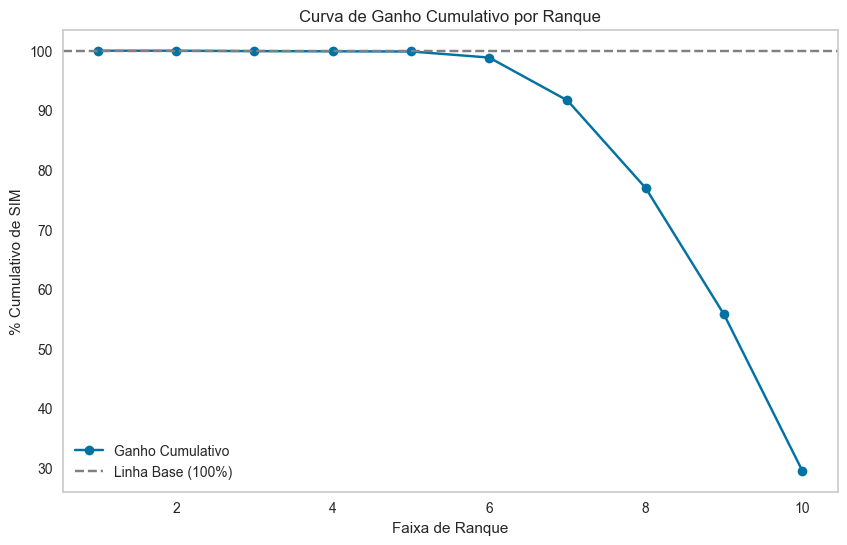

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(rank_metrics['Rank'], rank_metrics['Cumulative_Percent_SIM'], marker='o', label='Ganho Cumulativo')
plt.axhline(100, color='gray', linestyle='--', label='Linha Base (100%)')
plt.xlabel('Faixa de Ranque')
plt.ylabel('% Cumulativo de SIM')
plt.title('Curva de Ganho Cumulativo por Ranque')
plt.legend()
plt.grid()
plt.show()

In [ ]:
save_model(final_cat,'Modelo_Final_22_11_2024')

In [42]:
# Imports
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score, classification_report, confusion_matrix

# Balanceamento com ADASYN
adasyn = ADASYN(random_state=123)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)

# Reunir o DataFrame balanceado de treino
train_data_balanced = pd.concat([pd.DataFrame(X_train_balanced, columns=X.columns), 
                                 pd.DataFrame(y_train_balanced, columns=['response'])], axis=1)

# Configuração do PyCaret
s = setup(
    data=train_data_balanced,
    target='response',
    normalize=True,
    session_id=123,
    train_size=0.8,
    fold_strategy='stratifiedkfold',
    fold=10,
)

# Comparar modelos
best_model = compare_models()

# Selecionar e tunar o melhor modelo
final_model = tune_model(best_model, optimize='Recall')

# Ajuste do limiar de decisão
preds = predict_model(final_model, data=pd.concat([X_test, y_test], axis=1))
proba = preds['prediction_score']  # Probabilidade da classe positiva
threshold = 0.3  # Exemplo: ajustando o limiar para 0.3
final_preds = (proba >= threshold).astype(int)

# Avaliação no conjunto de teste
print("AUC no conjunto de teste:", roc_auc_score(y_test, proba))
print("\nRelatório de Classificação no conjunto de teste:")
print(classification_report(y_test, final_preds))

# Matriz de Confusão
cm = confusion_matrix(y_test, final_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Não', 'Sim'], yticklabels=['Não', 'Sim'])
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

,Description,Value
0,Session id,123
1,Target,response
2,Target type,Binary
3,Original data shape,"(538462, 14)"
4,Transformed data shape,"(538462, 14)"
5,Transformed train set shape,"(430769, 14)"
6,Transformed test set shape,"(107693, 14)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9133,0.9768,0.8702,0.9533,0.9099,0.8266,0.8298,8.9290
lightgbm,Light Gradient Boosting Machine,0.9030,0.9734,0.8713,0.9316,0.9004,0.8061,0.8079,0.8590
rf,Random Forest Classifier,0.9010,0.9725,0.8932,0.9084,0.9008,0.8020,0.8021,7.0820
et,Extra Trees Classifier,0.8955,0.9702,0.9069,0.8878,0.8973,0.7910,0.7911,3.8430
dt,Decision Tree Classifier,0.8819,0.8819,0.8880,0.8787,0.8833,0.7638,0.7638,0.4150
gbc,Gradient Boosting Classifier,0.8764,0.9608,0.9014,0.8597,0.8800,0.7526,0.7535,7.1890
ada,Ada Boost Classifier,0.8627,0.9532,0.8975,0.8406,0.8681,0.7253,0.7271,1.6160
knn,K Neighbors Classifier,0.8579,0.9322,0.8819,0.8429,0.8620,0.7157,0.7164,8.1580
lr,Logistic Regression,0.8275,0.9143,0.9013,0.7869,0.8402,0.6547,0.6619,0.4260
ridge,Ridge Classifier,0.8191,0.9084,0.9381,0.7592,0.8392,0.6376,0.6564,0.1060


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8197,0.9169,0.9476,0.7559,0.8410,0.6387,0.6607
1,0.8199,0.9164,0.9475,0.7563,0.8412,0.6393,0.6611
2,0.8167,0.9159,0.9493,0.7517,0.8390,0.6328,0.6563
3,0.8216,0.9166,0.9484,0.7578,0.8425,0.6425,0.6642
4,0.8183,0.9151,0.9475,0.7543,0.8399,0.6359,0.6582
5,0.8178,0.9162,0.9489,0.7532,0.8398,0.6351,0.6580
6,0.8219,0.9181,0.9488,0.7581,0.8428,0.6433,0.6650
7,0.8192,0.9165,0.9479,0.7552,0.8407,0.6378,0.6600
8,0.8195,0.9169,0.9516,0.7541,0.8414,0.6384,0.6619


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7036,0.8197,0.8148,0.2673,0.4025,0.2673,0.3409


KeyError: 'Score'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7036,0.8197,0.8148,0.2673,0.4025,0.2673,0.3409


AUC no conjunto de teste: 0.2231744912746776

Relatório de Classificação no conjunto de teste:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     66880
           1       0.12      1.00      0.22      9342

    accuracy                           0.12     76222
   macro avg       0.06      0.50      0.11     76222
weighted avg       0.02      0.12      0.03     76222



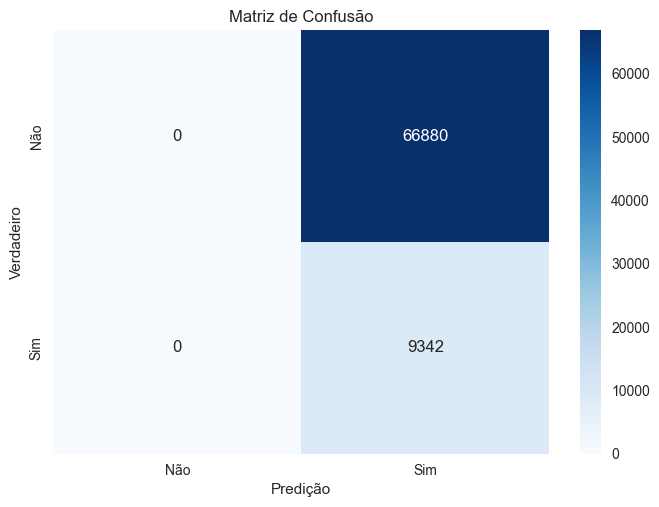

In [43]:
# Ajuste do limiar de decisão
preds = predict_model(final_model, data=pd.concat([X_test, y_test], axis=1))
proba = preds['prediction_score']  # Probabilidade da classe positiva
threshold = 0.3  # Exemplo: ajustando o limiar para 0.3
final_preds = (proba >= threshold).astype(int)

# Avaliação no conjunto de teste
print("AUC no conjunto de teste:", roc_auc_score(y_test, proba))
print("\nRelatório de Classificação no conjunto de teste:")
print(classification_report(y_test, final_preds))

# Matriz de Confusão
cm = confusion_matrix(y_test, final_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Não', 'Sim'], yticklabels=['Não', 'Sim'])
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()